### Analysis of city populations and CO2 emissions

This notebook presents an analysis of the CO2 emissions of large US cities (> 100K inhabitants) in relation to their population size and density.

The two data sources for this analysis are the US Census Data (where we will find the total population and from where we will retrieve the shape files with the surface areas to calculate the population density) and the Vulcan Project CO2 emissions dataset.

The work on the notebook is divided as suggested on the proposal (A sequence of steps that go from data wrangling to plotting, clustering, analysing and writing conclussions)

These steps are described bellow:


xx) Comment on the strength and weaknesses of this analysis, and on your findings (this is not the last step, but comments should be given throughout the notebook, and summarized here).

In [3]:
# Standard imports wo wotk with data, graphs, APIs, etc.

# Compatibility with Python 3
from __future__ import print_function, division
from censusreporter_api import * 

import pylab as pl
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import json
import requests
import urllib2
import urllib
import ast
from cStringIO import StringIO
# from get_jsonparsed_data import get_jsonparsed_data
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.interpolate import *
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
import zipfile
from geopandas import GeoDataFrame
import pysal as ps
from fiona.crs import from_epsg
import matplotlib.colors as mcolors
import operator
from matplotlib.colors import ListedColormap    
from IPython.display import Image
from IPython.core.display import HTML

# Horrible pandas plot bug
# http://stackoverflow.com/questions/33995707/attributeerror-unknown-property-color-cycle
#matplotlib.style.use('ggplot')

#loading rcParams from JSON template (created from Federica's fbb_matplotlibrc.json)
url = 'https://s3.amazonaws.com/sb-public/sbg389_matplotlibrc.json'
resp = requests.get(url=url)
data = json.loads(resp.text)
# update the rcParams object
pl.rcParams.update(data)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Anaconda2\lib\site-packages\matplotlib\__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Program Files\Anaconda2\lib\site-packages\matplotlib\__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Program Files\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['griddata', 'insert', 'polyint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 1. Retreive the curated data from the census and vulcan project

The census data used is from 2000, in order to match it to the available CO2 emissions data from the Vulcan project

    

In [4]:
# Quick test with the censusreporter API
# cant get to the level of the disagregated MSA :()

df = get_dataframe(tables='B01001',geoids='310|01000US',column_names=True,level=1)
df.sort('Total', ascending=False).head(5)

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,name,Total,Male,Female
31000US35620,"New York-Newark-Jersey City, NY-NJ-PA Metro Area",19979950.0,9655834.0,10324116.0
31000US31080,"Los Angeles-Long Beach-Anaheim, CA Metro Area",13154457.0,6484951.0,6669506.0
31000US16980,"Chicago-Naperville-Elgin, IL-IN-WI Metro Area",9534008.0,4660553.0,4873455.0
31000US19100,"Dallas-Fort Worth-Arlington, TX Metro Area",6833420.0,3362410.0,3471010.0
31000US26420,"Houston-The Woodlands-Sugar Land, TX Metro Area",6346653.0,3154038.0,3192615.0


In [5]:
# Download the curated summary census data file for 2000
xls_file = pd.ExcelFile('./DATA/2000CensusSummary.xlsx')
dfCensus = xls_file.parse('Sheet1')
dfCensus.head()

,Geographical Area,MSA,State,Population,Housing units,AreaSqMiles,DensitySqMile
0,"Abilene, TX MSA",Abilene,TX,126555,52056,919.25,138.2
1,"Albany, GA MSA",Albany,GA,120822,48469,696.65,176.3
2,"Albany-Schenectady-Troy, NY MSA",Albany-Schenectady-Troy,NY,875583,386262,3288.62,271.7
3,"Albuquerque, NM MSA",Albuquerque,NM,712738,298583,5951.18,119.9
4,"Alexandria, LA MSA",Alexandria,LA,126337,52038,1361.96,95.5


In [6]:
# Load a table containing the counties per MSA and FIPS codes
# We will use this DF to join it with the Vulcan County level Dataset
# And produce an aggregated per MSA Emissions DF

xls_file2 = pd.ExcelFile('./DATA/FIPSMSA-Counties.xlsx')
dfFIPSCodes = xls_file2.parse('Sheet1')
dfFIPSCodes.head()
#dfFIPSCodes.count()

,FIPS,GeographicArea,MSA,Counties
0,48441,"Abilene, TX MSA",Abilene,Taylor County
1,13095,"Albany, GA MSA",Albany,Dougherty County
2,13177,"Albany, GA MSA",Albany,Lee County
3,36001,"Albany-Schenectady-Troy, NY MSA",Albany-Schenectady-Troy,Albany County
4,36057,"Albany-Schenectady-Troy, NY MSA",Albany-Schenectady-Troy,Montgomery County


In [56]:
# Load a table containing the 2002 Vulcal Database Dataset
# With totals per geographic zone by sector

xls_file3 = pd.ExcelFile('./DATA/VulcanCountiesBySector.xls')
dfVulcanCountySector = xls_file3.parse('county_sector')
dfVulcanCountyPerCapita = xls_file3.parse('per capita')

dfVulcanCountyPerCapita.head()
#dfVulcanCountySector.head()

,State,County,FIPS,Pop 2000,Total,Commercial,Industrial,Residential,Electricity Prod,Onroad,Cement,Aircraft,Unknown,Nonroad,Transport
0,AL,Autauga,1001,43671,5.865829,0.068712,0.101527,0.232385,3.560907,1.711907,0.0,0.022345,0.056167,0.111879,1.902298
1,AL,Baldwin,1003,140415,3.205008,0.109306,0.084633,0.227529,0.000000,1.984894,0.0,0.127067,0.319406,0.352174,2.783541
2,AL,Barbour,1005,29038,3.422079,0.065589,0.294630,0.216390,0.000000,1.967854,0.0,0.188338,0.473422,0.215856,2.845471
3,AL,Bibb,1007,20826,2.206140,0.036914,0.077886,0.221569,0.000000,1.716397,0.0,0.018259,0.045897,0.089217,1.869771
4,AL,Blount,1009,51024,2.249456,0.038245,0.177553,0.218762,0.000000,1.712934,0.0,0.005841,0.014682,0.081440,1.814896


In [57]:
# Merge the MSA-Counties Dataframe with the VulcanCounty Dataframe
# We will obtain that way a DF that can be used later to aggregate emissions my MSA

DFMSACounties = pd.merge(dfFIPSCodes,dfVulcanCountySector,on='FIPS')
DFMSACountiesPerCapita = pd.merge(dfFIPSCodes,dfVulcanCountyPerCapita,on='FIPS')


In [58]:
DFMSACountiesPerCapita.head()

,FIPS,GeographicArea,MSA,Counties,State,County,Pop 2000,Total,Commercial,Industrial,Residential,Electricity Prod,Onroad,Cement,Aircraft,Unknown,Nonroad,Transport
0,48441,"Abilene, TX MSA",Abilene,Taylor County,TX,Taylor,126555,3.022838,0.176507,0.122232,0.216701,0.000000,1.970745,0.000000,0.119326,0.299949,0.117378,2.507398
1,13095,"Albany, GA MSA",Albany,Dougherty County,GA,Dougherty,96065,8.397459,0.148004,4.369584,0.161322,1.923182,1.424623,0.000000,0.073144,0.183861,0.113741,1.795368
2,13177,"Albany, GA MSA",Albany,Lee County,GA,Lee,24757,1.716133,0.030219,0.144130,0.052261,0.000000,1.313852,0.000000,0.000000,0.000000,0.175671,1.489523
3,36001,"Albany-Schenectady-Troy, NY MSA",Albany-Schenectady-Troy,Albany County,NY,Albany,294565,4.239967,0.417131,0.299923,0.542499,0.103907,1.612541,0.808433,0.099423,0.249918,0.106190,2.068072
4,36057,"Albany-Schenectady-Troy, NY MSA",Albany-Schenectady-Troy,Montgomery County,NY,Montgomery,49708,3.732602,0.165571,0.345317,0.549755,0.019780,2.406251,0.000000,0.000000,0.000000,0.245928,2.652179


In [59]:
DFMSACountiesPerCapita['AbsoluteTotal'] = DFMSACountiesPerCapita['Total'] * DFMSACountiesPerCapita['Pop 2000']
DFMSACountiesPerCapita = DFMSACountiesPerCapita[['MSA', 'AbsoluteTotal']]


In [60]:
DFMSACountiesPerCapita.head()

,MSA,AbsoluteTotal
0,Abilene,3.825553e+05
1,Albany,8.067019e+05
2,Albany,4.248631e+04
3,Albany-Schenectady-Troy,1.248946e+06
4,Albany-Schenectady-Troy,1.855402e+05


In [61]:
DFCO2PerMSA = DFMSACounties.groupby(['MSA'], as_index=False).sum()

DFCO2PerMSAPerCapita = DFMSACountiesPerCapita.groupby(['MSA'], as_index=False).sum()



In [62]:
DFCO2PerMSAPerCapita.head()

,MSA,AbsoluteTotal
0,Abilene,3.825553e+05
1,Akron,2.048257e+06
2,Albany,8.491882e+05
3,Albany-Schenectady-Troy,3.002046e+06
4,Albuquerque,2.141536e+06


In [63]:
# Merge with the census data to bring the area and population

In [64]:
dfCensus.head()

,Geographical Area,MSA,State,Population,Housing units,AreaSqMiles,DensitySqMile
0,"Abilene, TX MSA",Abilene,TX,126555,52056,919.25,138.2
1,"Albany, GA MSA",Albany,GA,120822,48469,696.65,176.3
2,"Albany-Schenectady-Troy, NY MSA",Albany-Schenectady-Troy,NY,875583,386262,3288.62,271.7
3,"Albuquerque, NM MSA",Albuquerque,NM,712738,298583,5951.18,119.9
4,"Alexandria, LA MSA",Alexandria,LA,126337,52038,1361.96,95.5


In [65]:
DFMSACO2 = pd.merge(DFCO2PerMSA,dfCensus,on='MSA')

DFMSACO2PerCapita = pd.merge(DFCO2PerMSAPerCapita,dfCensus,on='MSA')


DFMSACO2PerCapita.count()

MSA                  263
AbsoluteTotal        263
Geographical Area    263
State                263
Population           263
Housing  units       263
AreaSqMiles          263
DensitySqMile        263
dtype: int64

In [66]:
#DFMSACO2['Population'] = DFMSACO2['Population'].astype(int)

DFMSACO2 = DFMSACO2[(DFMSACO2['Population'] >= 100000)]

DFMSACO2PerCapita = DFMSACO2PerCapita[(DFMSACO2PerCapita['Population'] >= 100000)]

DFMSACO2PerCapita.count()

MSA                  247
AbsoluteTotal        247
Geographical Area    247
State                247
Population           247
Housing  units       247
AreaSqMiles          247
DensitySqMile        247
dtype: int64

In [67]:
DFMSACO2PerCapita.sort_values(['AbsoluteTotal'], ascending=[False])

,MSA,AbsoluteTotal,Geographical Area,State,Population,Housing units,AreaSqMiles,DensitySqMile
45,Chicago,3.153615e+07,"Chicago, IL PMSA",IL,8272768,3132638,6712.20,1634.2
107,Houston,2.820614e+07,"Houston, TX PMSA",TX,4177646,1575541,6307.26,705.7
63,Detroit,2.539453e+07,"Detroit, MI PMSA",MI,4441551,1794737,4329.72,1139.8
143,Los Angeles-Long Beach,2.131600e+07,"Los Angeles--Long Beach, CA PMSA",CA,9519338,3270909,4752.32,2344.2
13,Atlanta,2.108347e+07,"Atlanta, GA MSA",GA,4112198,1589568,6207.94,671.5
166,New York,1.827106e+07,"New York, NY PMSA",NY,9314235,3680360,1414.55,8158.7
47,Cleveland-Lorain-Elyria,1.772866e+07,"Cleveland--Lorain--Elyria, OH PMSA",OH,2250871,955148,5347.31,831.5
181,Pittsburgh,1.273168e+07,"Pittsburgh, PA MSA",PA,2358695,1046094,4678.69,509.9
26,Birmingham,1.173182e+07,"Birmingham, AL MSA",AL,921106,395925,3237.54,289.1
234,Tampa-St. Petersburg-Clearwater,1.173125e+07,"Tampa--St. Petersburg--Clearwater, FL MSA",FL,2395997,1143979,3330.93,938.1


In [68]:
DFMSACO2PerCapita['TotalPerCapita'] = DFMSACO2PerCapita['AbsoluteTotal'] / DFMSACO2PerCapita['Population']
DFMSACO2PerCapita.sort_values(['TotalPerCapita'], ascending=[False])

,MSA,AbsoluteTotal,Geographical Area,State,Population,Housing units,AreaSqMiles,DensitySqMile,TotalPerCapita
115,Jacksonville,7.262519e+06,"Jacksonville, NC MSA",NC,150355,55726,908.56,196.1,48.302477
79,Florence,5.283931e+06,"Florence, SC MSA",SC,125761,51836,803.74,157.2,42.015653
98,Green Bay,9.269555e+06,"Green Bay, WI MSA",WI,226778,90199,615.42,429.0,40.875020
78,Florence,5.283931e+06,"Florence, AL MSA",AL,142950,65404,1342.39,113.1,36.963488
196,Rochester,4.227884e+06,"Rochester, MN MSA",MN,124277,49422,654.50,190.3,34.019846
49,Columbia,3.531983e+06,"Columbia, MO MSA",MO,135454,56678,691.31,197.6,26.075151
235,Terre Haute,3.850022e+06,"Terre Haute, IN MSA",IN,149192,63705,1030.80,146.6,25.805818
41,Charleston,5.923797e+06,"Charleston, WV MSA",WV,251662,115409,1261.39,201.4,23.538702
113,Jackson,2.310900e+06,"Jackson, TN MSA",TN,107377,44383,847.37,127.0,21.521367
124,Kenosha,2.686905e+06,"Kenosha, WI PMSA",WI,149577,59989,754.31,548.2,17.963355


In [69]:
DFMSACO2PerCapita.to_csv('./DATA/DFMSACO2PerCapita.csv')

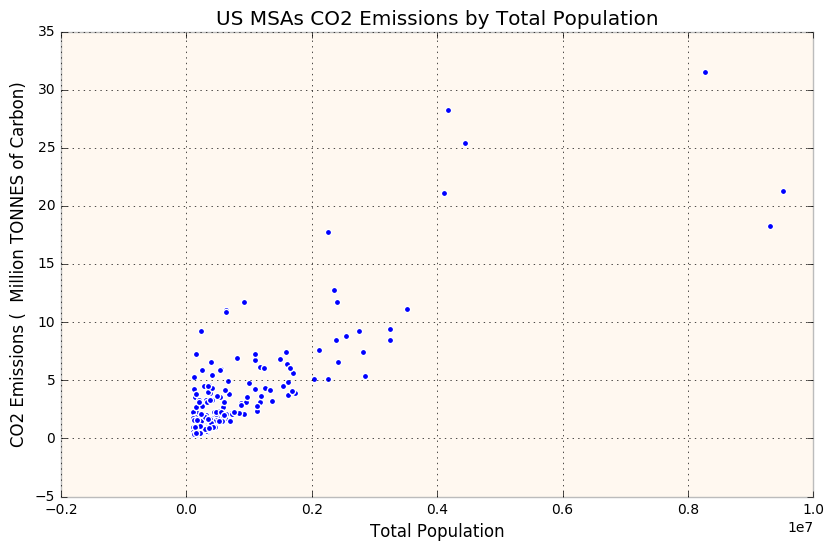

In [45]:
pl.figure(figsize=(6 * 1.618, 6))
pl.ylabel("CO2 Emissions (  Million TONNES of Carbon)")
pl.xlabel("Total Population")
pl.scatter(DFMSACO2.Population, DFMSACO2[' Total'])
pl.title('US MSAs CO2 Emissions by Total Population')


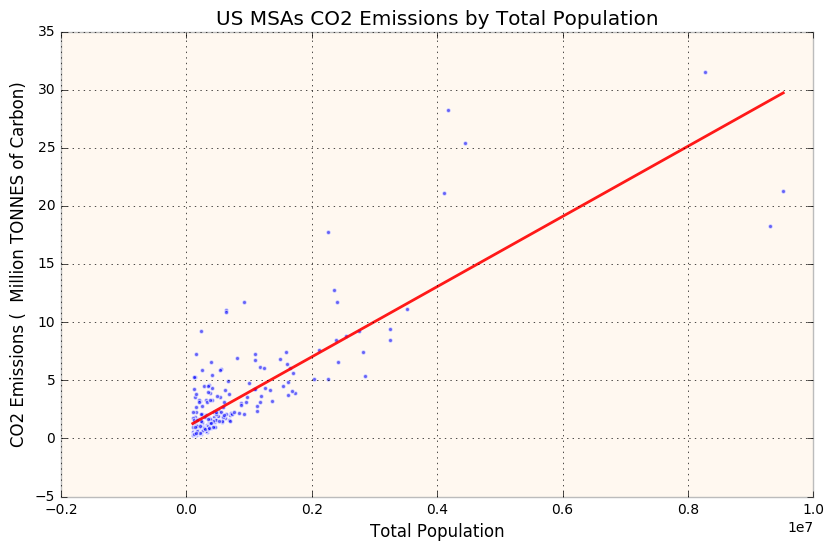

In [46]:
y = DFMSACO2[' Total']  # response
X = DFMSACO2.Population  # predictor
X = sm.add_constant(X)  # Adds a constant term to the predictor

# use the sm OLS method passing the y (existing data for what i want to predict) and the predictor X
est = (sm.OLS(y, X))

# run the fit method
est = est.fit()
# Pick 100 hundred points equally spaced from the min to the max
X_prime = np.linspace(X['Population'].min(), X['Population'].max(), 100)[:, np.newaxis]
X_prime = sm.add_constant(X_prime)  # add constant as we did before

# Now we calculate the predicted values
y_hat = est.predict(X_prime)

pl.figure(figsize=(6 * 1.618, 6))
pl.ylabel("CO2 Emissions (  Million TONNES of Carbon)")
pl.xlabel("Total Population")
pl.scatter(DFMSACO2.Population, DFMSACO2[' Total'], s=10, alpha=0.6 )
pl.plot(X_prime[:, 1], y_hat, 'r', alpha=0.9)
pl.title('US MSAs CO2 Emissions by Total Population')

In [47]:
# Slope of the line

In [48]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Total   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     549.7
Date:                Mon, 06 Feb 2017   Prob (F-statistic):           1.52e-64
Time:                        14:41:20   Log-Likelihood:                -568.55
No. Observations:                 247   AIC:                             1141.
Df Residuals:                     245   BIC:                             1148.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.9718      0.179      5.418      0.000         0.618     1.325
Population   3.02e-06   1.29e-07     23.446      0.000      2.77e-06  3.27e-06
==============================================================================
Omnibus:                      135.826   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1295.781
Skew:                           1.973   Prob(JB):                    4.21e-282
Kurtosis:                      13.504   Cond. No.                     1.62e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

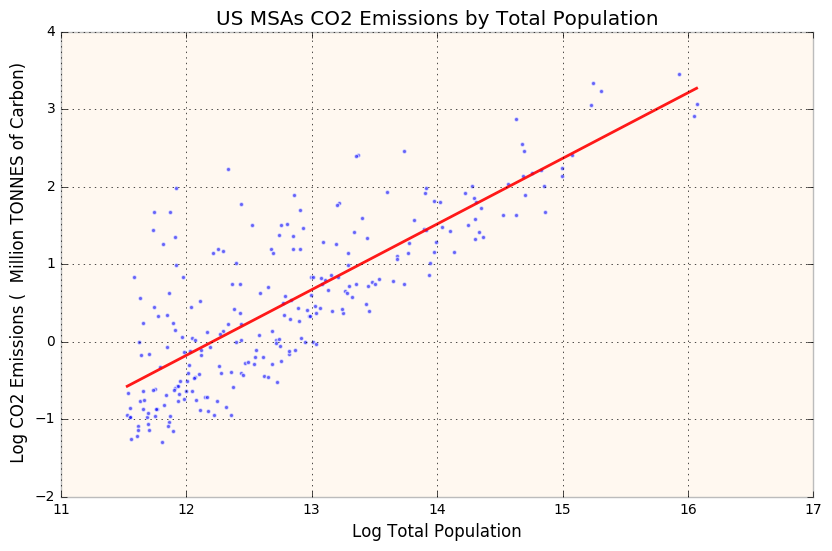

In [49]:
y = log(DFMSACO2[' Total'])  # response
X = log(DFMSACO2.Population)  # predictor
X = sm.add_constant(X)  # Adds a constant term to the predictor

# use the sm OLS method passing the y (existing data for what i want to predict) and the predictor X
est = (sm.OLS(y, X))

# run the fit method
est = est.fit()
# Pick 100 hundred points equally spaced from the min to the max
X_prime = np.linspace(X['Population'].min(), X['Population'].max(), 100)[:, np.newaxis]
X_prime = sm.add_constant(X_prime)  # add constant as we did before

# Now we calculate the predicted values
y_hat = est.predict(X_prime)

pl.figure(figsize=(6 * 1.618, 6))
pl.ylabel(" Log CO2 Emissions (  Million TONNES of Carbon)")
pl.xlabel("Log Total Population")
#pl.text(0,-13,'Fig I: Total CO2 Emissions (Millons of Tons) by total population')
pl.scatter(log(DFMSACO2.Population), log(DFMSACO2[' Total']), s=10, alpha=0.6 )
pl.plot(X_prime[:, 1], y_hat, 'r', alpha=0.9)
pl.title('US MSAs CO2 Emissions by Total Population')

In [50]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Total   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     427.4
Date:                Mon, 06 Feb 2017   Prob (F-statistic):           1.25e-55
Time:                        14:41:24   Log-Likelihood:                -240.82
No. Observations:                 247   AIC:                             485.6
Df Residuals:                     245   BIC:                             492.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -10.3399      0.527    -19.602      0.000       -11.379    -9.301
Population     0.8468      0.041     20.673      0.000         0.766     0.928
==============================================================================
Omnibus:                       42.791   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.751
Skew:                           1.104   Prob(JB):                     1.06e-13
Kurtosis:                       3.964   Cond. No.                         167.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

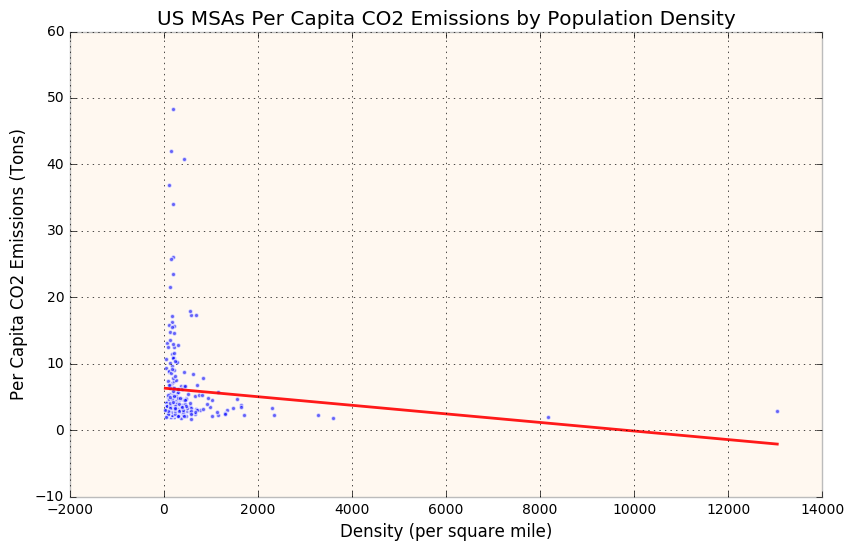

In [51]:
# Density

y = DFMSACO2PerCapita['TotalPerCapita']  # response
X = DFMSACO2PerCapita.DensitySqMile  # predictor
X = sm.add_constant(X)  # Adds a constant term to the predictor

# use the sm OLS method passing the y (existing data for what i want to predict) and the predictor X
est = (sm.OLS(y, X))

# run the fit method
est = est.fit()
# Pick 100 hundred points equally spaced from the min to the max
X_prime = np.linspace(X['DensitySqMile'].min(), X['DensitySqMile'].max(), 100)[:, np.newaxis]
X_prime = sm.add_constant(X_prime)  # add constant as we did before

# Now we calculate the predicted values
y_hat = est.predict(X_prime)

pl.figure(figsize=(6 * 1.618, 6))
pl.xlabel("Density (per square mile)")
pl.ylabel("Per Capita CO2 Emissions (Tons)")
#pl.text(0,-13,'Fig I: Total CO2 Emissions (Millons of Tons) by total population')
pl.scatter (DFMSACO2PerCapita.DensitySqMile, DFMSACO2PerCapita['TotalPerCapita'], s=10, alpha=0.6 )
pl.plot(X_prime[:, 1], y_hat, 'r', alpha=0.9)
pl.title('US MSAs Per Capita CO2 Emissions by Population Density')

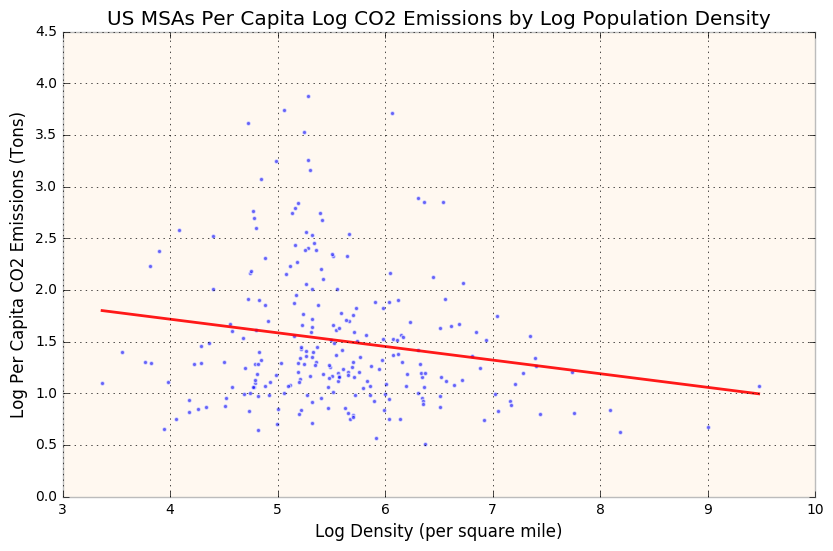

In [52]:
#Log Density

y = log(DFMSACO2PerCapita['TotalPerCapita'])  # response
X = log(DFMSACO2PerCapita.DensitySqMile)  # predictor
X = sm.add_constant(X)  # Adds a constant term to the predictor

# use the sm OLS method passing the y (existing data for what i want to predict) and the predictor X
est = (sm.OLS(y, X))

# run the fit method
est = est.fit()
# Pick 100 hundred points equally spaced from the min to the max
X_prime = np.linspace(X['DensitySqMile'].min(), X['DensitySqMile'].max(), 100)[:, np.newaxis]
X_prime = sm.add_constant(X_prime)  # add constant as we did before

# Now we calculate the predicted values
y_hat = est.predict(X_prime)

pl.figure(figsize=(6 * 1.618, 6))
pl.xlabel("Log Density (per square mile)")
pl.ylabel("Log Per Capita CO2 Emissions (Tons)")
#pl.text(0,-13,'Fig I: Total CO2 Emissions (Millons of Tons) by total population')
pl.scatter(log(DFMSACO2PerCapita.DensitySqMile), log(DFMSACO2PerCapita['TotalPerCapita']), s=10, alpha=0.6 )
pl.plot(X_prime[:, 1], y_hat, 'r', alpha=0.9)
pl.title('US MSAs Per Capita Log CO2 Emissions by Log Population Density')

In [53]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         TotalPerCapita   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     8.120
Date:                Mon, 06 Feb 2017   Prob (F-statistic):            0.00475
Time:                        14:41:34   Log-Likelihood:                -243.64
No. Observations:                 247   AIC:                             491.3
Df Residuals:                     245   BIC:                             498.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             2.2433      0.261      8.600      0.000         1.730     2.757
DensitySqMile    -0.1319      0.046     -2.849      0.005        -0.223    -0.041
==============================================================================
Omnibus:                       51.716   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               80.229
Skew:                           1.214   Prob(JB):                     3.79e-18
Kurtosis:                       4.378   Cond. No.                         36.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
# Remove outliers

#DFMSACO2['Population'] = DFMSACO2['Population'].astype(int)

DFMSACO2PerCapita = DFMSACO2PerCapita[(DFMSACO2PerCapita['DensitySqMile'] <= 2000)]
DFMSACO2PerCapita = DFMSACO2PerCapita[(DFMSACO2PerCapita['TotalPerCapita'] <= 20)]


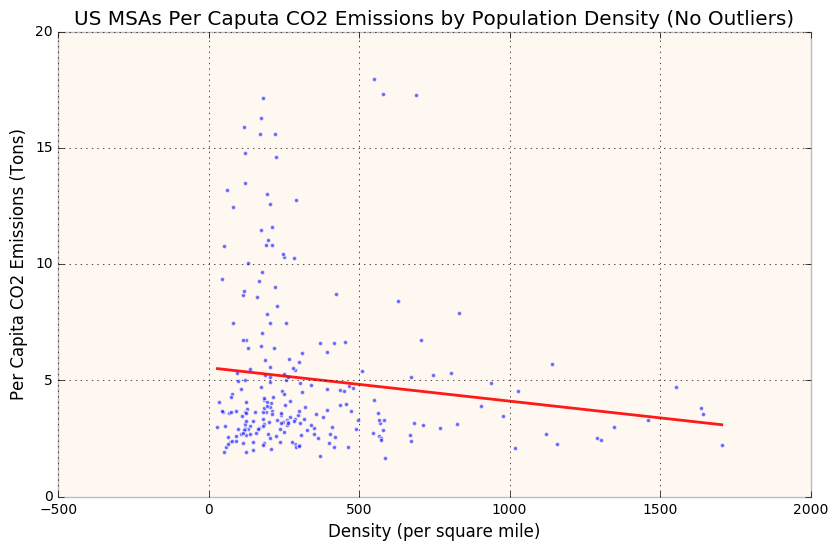

In [55]:
# Density

y = DFMSACO2PerCapita['TotalPerCapita']  # response
X = DFMSACO2PerCapita.DensitySqMile  # predictor
X = sm.add_constant(X)  # Adds a constant term to the predictor

# use the sm OLS method passing the y (existing data for what i want to predict) and the predictor X
est = (sm.OLS(y, X))

# run the fit method
est = est.fit()
# Pick 100 hundred points equally spaced from the min to the max
X_prime = np.linspace(X['DensitySqMile'].min(), X['DensitySqMile'].max(), 100)[:, np.newaxis]
X_prime = sm.add_constant(X_prime)  # add constant as we did before

# Now we calculate the predicted values
y_hat = est.predict(X_prime)

pl.figure(figsize=(6 * 1.618, 6))
pl.xlabel("Density (per square mile)")
pl.ylabel("Per Capita CO2 Emissions (Tons)")
#pl.text(0,-13,'Fig I: Total CO2 Emissions (Millons of Tons) by total population')
pl.scatter (DFMSACO2PerCapita.DensitySqMile, DFMSACO2PerCapita['TotalPerCapita'], s=10, alpha=0.6 )
pl.plot(X_prime[:, 1], y_hat, 'r', alpha=0.9)
pl.title('US MSAs Per Caputa CO2 Emissions by Population Density (No Outliers)')